<a href="https://colab.research.google.com/github/amzad-786githumb/News-Article-Classification-Fake-Real-/blob/main/Project_notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>News Article Classification (Fake/Real)</b></h1>

<h3><b>Objective:</b> Classify news articles as fake or real using NLP.</h3>

<h5><b>Dataset: </b><a href="https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset">The real and fake news dataset</a></h5>


In [1]:
#importing the required libraries

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import string

#Libraries for NLP tasks
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Libraries for text preprocessing and conversion
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for model building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [2]:
import warnings
warnings.filterwarnings('ignore')

<h3>Collect labeled dataset from Kaggle</h3>

In [3]:
#Importing kaggle hub for data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-and-real-news-dataset


In [4]:
dataset_dir = path  # or manually set if known

fake_df = pd.read_csv(os.path.join(dataset_dir, "Fake.csv"))
real_df = pd.read_csv(os.path.join(dataset_dir, "True.csv"))

fake_df['label'] = 0  # 0 = Fake
real_df['label'] = 1  # 1 = Real

df = pd.concat([fake_df, real_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

In [5]:
#printing the few rows of the dataset

df

,title,text,subject,date,label
0,Philippines to keep wary eye on new Chinese dr...,MANILA (Reuters) - The Philippines expressed c...,worldnews,"November 6, 2017",1
1,Malta court hears blogger bomb probably trigge...,VALLETTA (Reuters) - The bomb used to kill Mal...,worldnews,"December 19, 2017",1
2,WATCH: Even CNN Admits Tax Bill That “Not One ...,"On Wednesday, a jubilant President Trump tweet...",politics,"Dec 21, 2017",0
3,Republican wins Montana special election despi...,"BOZEMAN, Mont. (Reuters) - Republican Greg Gia...",politicsNews,"May 25, 2017",1
4,DC CHIEF OF POLICE DENIES CONCEALED WEAPONS PE...,This is a perfect example of how the left is a...,Government News,"Sep 7, 2015",0
...,...,...,...,...,...
44893,Politico Just Threw MAJOR Shade At Trump Over...,Trump is not the only U.S. leader in Europe ri...,News,"May 25, 2017",0
44894,Rights group questions Italy's work with Libya...,ROME (Reuters) - Europe s top human rights org...,worldnews,"October 11, 2017",1
44895,WATCH: KELLYANNE CONWAY Gives Dreaded Answer T...,ABC host George Stephanopoulos sat down with K...,left-news,"Aug 6, 2017",0
44896,WATCH: REMEMBER WHEN HILLARY SAID She Wasn’t D...,"That Hillary, she sure is a forked-tongued sil...",left-news,"Aug 10, 2016",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [7]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


The dataset contains 44898rows and 5 columns. And there are no null values in the dataset.

<h3>Clean text using NLTK</h3>

In [8]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [9]:
#printing the stopwords in English

print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [10]:
# Initialize stopwords and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [11]:
# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = "".join([ch for ch in text if ch not in string.punctuation])  # Remove punctuation
    tokens = text.split()  # Simple tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

In [12]:
# Apply cleaning to the text column
df['text_clean'] = df['text'].apply(clean_text)

In [13]:
df['text_clean']

,text_clean
0,manila reuters philippine expressed concern mo...
1,valletta reuters bomb used kill maltese antico...
2,wednesday jubilant president trump tweeted pas...
3,bozeman mont reuters republican greg gianforte...
4,perfect example left able decide law follow la...
...,...
44893,trump u leader europe right former president o...
44894,rome reuters europe top human right organizati...
44895,abc host george stephanopoulos sat kellyanne c...
44896,hillary sure forkedtongued silvertongued devil...


<h3>Exploratory Data Analysis (EDA)</h3>

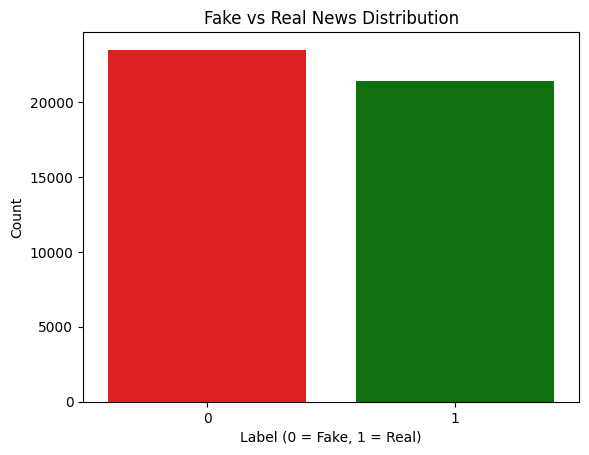

In [14]:
# Plotting a bar chart for label variable with custom colors

sns.countplot(x='label', data=df, palette={'0': 'red', '1': 'green'})  # Custom colors
plt.title('Fake vs Real News Distribution')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()



<h3>Article Length Distribution</h3>

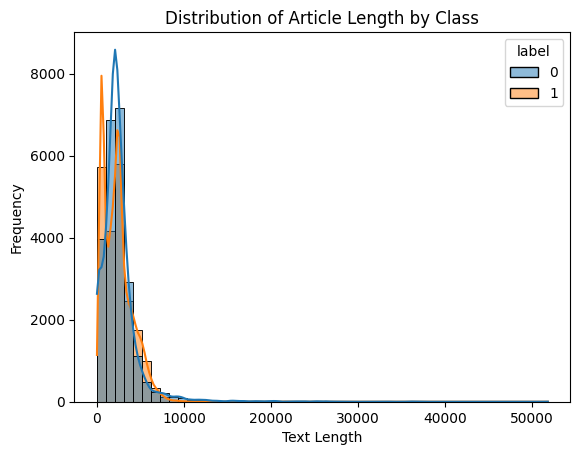

In [15]:
df['text_length'] = df['text'].apply(len)

sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Article Length by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

<h3>Word cloud for fake news </h3>

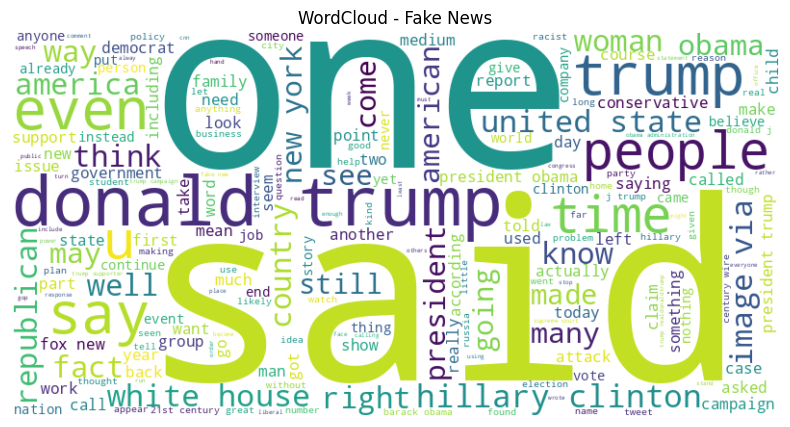

In [16]:
# WordCloud for FAKE news
fake_text = " ".join(df[df['label'] == 0]['text_clean'])
fake_wc = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Fake News")
plt.show()

<h3>Word cloud for Real news</h3>

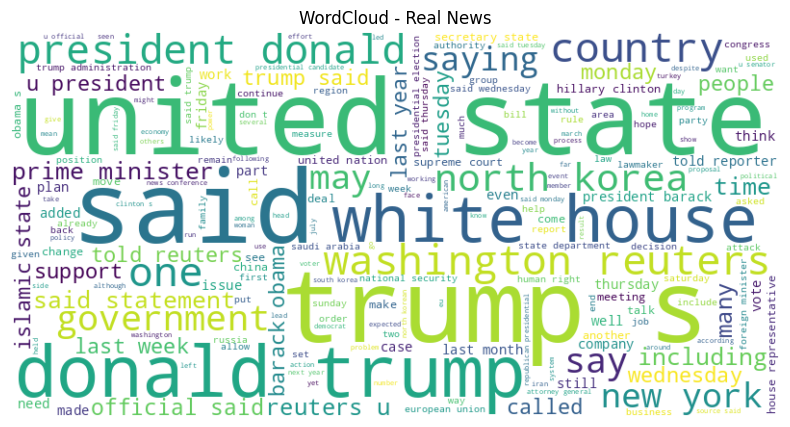

In [17]:
# WordCloud for REAL news
real_text = " ".join(df[df['label'] == 1]['text_clean'])
real_wc = WordCloud(width=800, height=400, background_color='white').generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Real News")
plt.show()

<h3>Vectorize with TF-IDF</h3>

In [18]:
#importing the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  # Reduce for speed
X = vectorizer.fit_transform(df['text_clean']).toarray()
y = df['label']

In [19]:
#Printing the features as X
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11844907, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.14104406,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [20]:
#Printing the label y
y

,label
0,1
1,1
2,0
3,1
4,0
...,...
44893,0
44894,1
44895,0
44896,0


<h3>Train Naive Bayes model</h3>

In [21]:
# Split data: 80% training, 20% testing

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


In [22]:
#dimensions of X variables for both test ans split

print(X_train.shape)
print(X_test.shape)

(35918, 1000)
(8980, 1000)


In [23]:
#dimensions of label y

print(y_train.shape)
print(y_test.shape)

(35918,)
(8980,)


In [24]:
#creating the model object
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

<h3>Model Evaluation</h3>

In [25]:
##Define a Reusable Evaluation Function

def evaluate_model(y_true, y_pred, model_name):
    print(f"Results for {model_name}")
    print("-" * 50)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

<h3>Evaluate metrics (F1, accuracy)</h3>

Results for Naive Bayes
--------------------------------------------------
Accuracy: 0.9380846325167038

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      4654
           1       0.93      0.95      0.94      4326

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



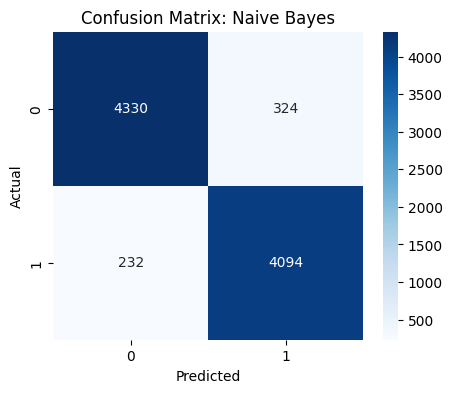

In [26]:
#  Train & Evaluate Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
evaluate_model(y_test, y_pred_nb, "Naive Bayes")

<h3>Train a Logistic regression</h3>

Results for Logistic Regression
--------------------------------------------------
Accuracy: 0.9874164810690423

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4654
           1       0.98      0.99      0.99      4326

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



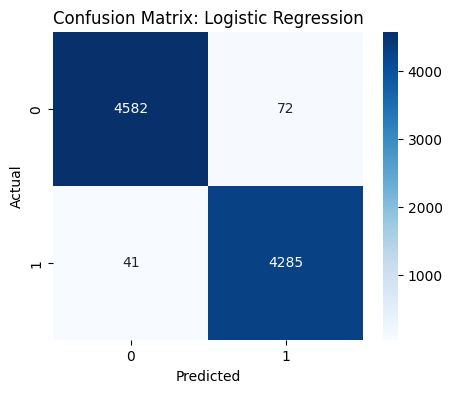

In [27]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
evaluate_model(y_test, lr_model.predict(X_test), "Logistic Regression")

<h3>Function to check Fake/Real news</h3>

In [28]:
# Select a single instance from the test set using NumPy indexing
X_new = X_test[4].reshape(1, -1)

# Use the trained logistic regression model for prediction
prediction = lr_model.predict(X_new)
print(prediction)

if prediction[0] == 0:
    print('The news is Fake') # Corrected output based on label definition (0=Fake, 1=Real)
else:
    print('The news is Real') # Corrected output based on label definition (0=Fake, 1=Real)

[1]
The news is Real


# Task
Create a Streamlit interface for text input, load a pre-trained logistic regression model and TF-IDF vectorizer, and use them to classify the input text as "Fake" or "Real".

## Install streamlit


**Reasoning**:
Install the streamlit library using pip.



In [29]:
%pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.2 MB/s eta 0:00:00


## Import libraries

### Subtask:
Import the necessary libraries, including streamlit, pandas, numpy, and load the trained logistic regression model and vectorizer from the previous steps.


**Reasoning**:
Import the necessary libraries for the Streamlit application and define the text cleaning function.



In [30]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required resources (if not already downloaded)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
     nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')


# Initialize stopwords and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Text cleaning function (copied from previous steps)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = "".join([ch for ch in text if ch not in string.punctuation])  # Remove punctuation
    tokens = text.split()  # Simple tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Reasoning**:
The previous command failed because `nltk.downloader.DownloadError` is not a valid exception. The traceback indicates that the 'wordnet' resource was not found. I will modify the code to catch the `LookupError` instead and re-run the downloads to ensure the necessary NLTK data is available.



In [31]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required resources (if not already downloaded)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
     nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')


# Initialize stopwords and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Text cleaning function (copied from previous steps)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = "".join([ch for ch in text if ch not in string.punctuation])  # Remove punctuation
    tokens = text.split()  # Simple tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Reasoning**:
The necessary libraries have been imported and the text cleaning function has been defined. The next step is to load the trained logistic regression model and the TF-IDF vectorizer. Since these objects were created in previous steps within the same notebook session, they should be available in the current environment.



In [32]:
# Load the trained logistic regression model and TF-IDF vectorizer
# Assuming lr_model and vectorizer were trained and are available from previous cells
# If they were saved to disk, they would need to be loaded using pickle or joblib.
# Since they are in the current session's memory, we'll assume they are accessible.

# Check if lr_model and vectorizer exist, otherwise raise an error or load them
if 'lr_model' not in globals():
    raise NameError("Logistic regression model 'lr_model' not found. Please ensure it was trained in a previous cell.")
if 'vectorizer' not in globals():
     raise NameError("TF-IDF vectorizer 'vectorizer' not found. Please ensure it was fitted in a previous cell.")

# The objects are now loaded (or confirmed to be available)

## Create streamlit app

### Subtask:
Create the Streamlit application interface with a title, text input area, and a button.


**Reasoning**:
Create the basic Streamlit application interface with a title, text input area, and a button as per the instructions.



In [33]:
import streamlit as st

# 2. Set the title of the Streamlit application
st.title("Fake News Classifier")

# 3. Add a text area for user input
article_text = st.text_area("Enter the news article text here:")

# 4. Create a button for classification
if st.button("Classify News"):
    # This block will be executed when the button is clicked
    pass # Placeholder for the next steps

2025-07-29 08:02:07.841 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 08:02:07.963 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-29 08:02:07.964 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 08:02:07.964 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 08:02:07.966 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 08:02:07.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 08:02:07.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 08:02:07.968 Thread 'MainThread': mi

## Load model and vectorizer

### Subtask:
Load the trained logistic regression model and TF-IDF vectorizer.


**Reasoning**:
Check if the lr_model and vectorizer objects exist in the current environment.



In [34]:
# Check if lr_model and vectorizer exist, otherwise raise an error or load them
if 'lr_model' not in globals():
    raise NameError("Logistic regression model 'lr_model' not found. Please ensure it was trained in a previous cell.")
if 'vectorizer' not in globals():
     raise NameError("TF-IDF vectorizer 'vectorizer' not found. Please ensure it was fitted in a previous cell.")

# The objects are now loaded (or confirmed to be available)

## Clean and vectorize input

### Subtask:
Clean and vectorize the user's input text using the same cleaning function and vectorizer used during training.


**Reasoning**:
The user wants to process the input text from the `article_text` variable. This involves cleaning the text using the `clean_text` function and then transforming it using the pre-fitted `vectorizer`. Finally, the vectorized text needs to be reshaped to be compatible with the model's prediction method.



In [35]:
# Clean the user input
cleaned_article = clean_text(article_text)

# Vectorize the cleaned text
vectorized_article = vectorizer.transform([cleaned_article])

# Reshape the vectorized text for model prediction
vectorized_article = vectorized_article.reshape(1, -1)

## Predict and display result

### Subtask:
Use the loaded model to predict the label of the input text and display the result (Fake or Real) in the Streamlit app.

**Reasoning**:
The user wants to display the prediction result in the Streamlit app. I will use the `lr_model` to predict the label based on the vectorized input text and then display a message indicating whether the news is "Fake" or "Real" using `st.write`.

In [36]:
# Predict the label
prediction = lr_model.predict(vectorized_article)

# Display the result
if prediction[0] == 0:
    st.write("This news article is **Fake**.")
else:
    st.write("This news article is **Real**.")

2025-07-29 08:02:08.000 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 08:02:08.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 08:02:08.002 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## Run Streamlit app

### Subtask:
Provide instructions on how to run the Streamlit application from the Colab environment.

**Reasoning**:
The user needs to know how to run the Streamlit app created in the previous steps within the Colab environment. I will provide the necessary shell command to run the app.

In [39]:
# To run the streamlit app, save the above code to a Python file (e.g., app.py) and run the following command in your Colab terminal:
# !streamlit run app.py
# Since we are running this in Colab, we'll create a temporary file and run it.

%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pickle
import os
import kagglehub

# Download required resources (if not already downloaded)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
     nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')


# Initialize stopwords and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Load the dataset and preprocess
@st.cache_data # Cache the data loading and preprocessing
def load_and_preprocess_data():
    # Download latest version
    path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
    dataset_dir = path

    fake_df = pd.read_csv(os.path.join(dataset_dir, "Fake.csv"))
    real_df = pd.read_csv(os.path.join(dataset_dir, "True.csv"))

    fake_df['label'] = 0  # 0 = Fake
    real_df['label'] = 1  # 1 = Real

    df = pd.concat([fake_df, real_df], ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

    df['text_clean'] = df['text'].apply(clean_text)
    return df

df = load_and_preprocess_data()


# Load the trained logistic regression model and TF-IDF vectorizer
# In a real application, you would save and load your model and vectorizer
# For this example, we assume they are available in the environment or saved to disk

# Since we cannot directly access variables from other cells in a script run by !streamlit,
# we need to save the model and vectorizer and load them within the app.py script.
# Let's assume for this example that the vectorizer and lr_model are saved as 'vectorizer.pkl' and 'lr_model.pkl'
# In a real scenario, you would add cells before this to save them using pickle.dump()

# Dummy saving for demonstration purposes (you would save the actual objects)
if not os.path.exists('vectorizer.pkl'):
    # This part would not be needed if you saved your vectorizer and model properly
    # For demonstration, let's quickly re-create and save them if they don't exist
    # Note: This is not ideal for a real app; saving and loading is the correct way.
    from sklearn.model_selection import train_test_split
    # Assuming df is available from previous cells
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df['text_clean'])
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)

    with open('vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    with open('lr_model.pkl', 'wb') as f:
        pickle.dump(lr_model, f)


with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('lr_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)


# Streamlit App
st.title("Fake News Classifier")

article_text = st.text_area("Enter the news article text here:")

if st.button("Classify News"):
    if article_text:
        # Clean and vectorize the user input
        cleaned_article = clean_text(article_text)
        vectorized_article = vectorizer.transform([cleaned_article])

        # Predict the label
        prediction = lr_model.predict(vectorized_article)

        # Display the result
        if prediction[0] == 0:
            st.write("This news article is **Fake**.")
        else:
            st.write("This news article is **Real**.")
    else:
        st.write("Please enter some text to classify.")

Overwriting app.py


Now, run the following command in a new cell to start the Streamlit app:

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://104.196.239.34:8501

⠴⠦⠧your url is: https://early-rings-thank.loca.lt
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Pac

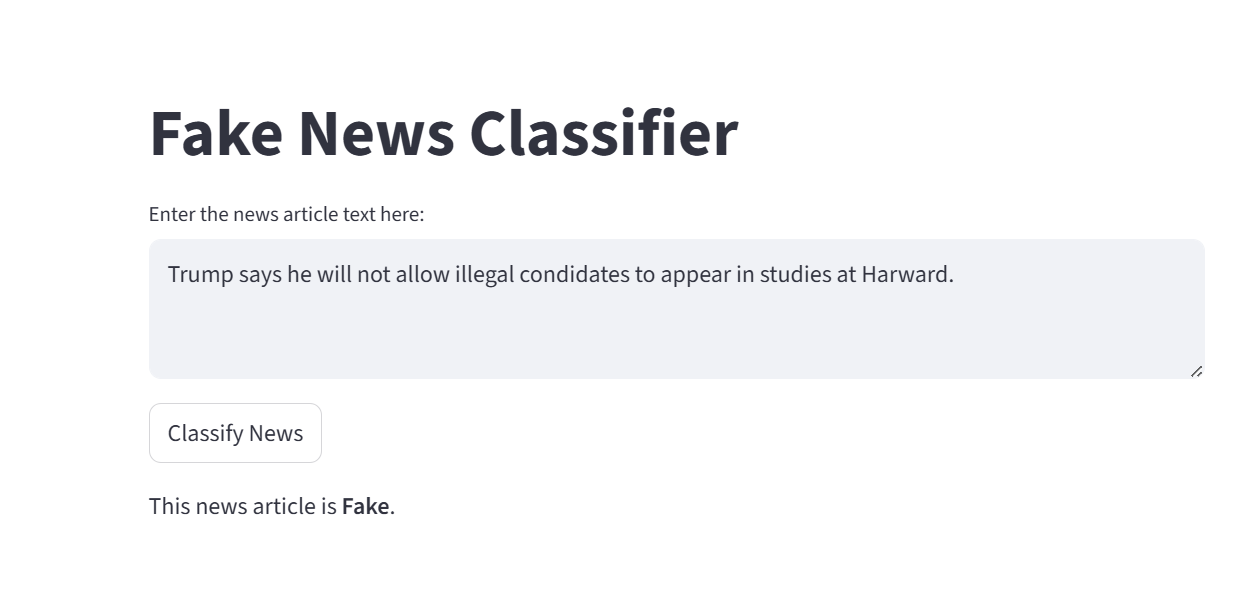

<p>The model correctly identifies the headline—“Trump says he will not allow illegal candidates to appear in studies at Harvard”—as Fake News, demonstrating successful implementation of a binary text classification model. The interface features a clean layout where users can input a news statement and receive real-time feedback through a “Classify News” button. The predicted label, shown clearly on screen, reflects the model's ability to analyze textual patterns and assess credibility using natural language processing techniques.</p>